In [1]:
# We start with some useful jupyter magic
%load_ext autoreload
%autoreload 2

In [2]:
# My big fat greek import list:
# Now we import a number of python packages that will be useful later on. I'm going to comment on some notable ones
import sys   # sys helps you manipulate environmental variable (e.g. $PWD) from you python environment
import localSettings as ls  # localSettings.py is a python script you should have in the PELEE folder: check if you do
import math

# What time is it? It's time to profile your code! datetime helps you estimating how long part of your code take to run 
# so you know what's worth spending time optimizing (and what isn't)
from datetime import datetime
import time
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

# plotter.py is where the plotter class is define (a lot of the plotting matplotlib magic happens there)
import plotter
import importlib
importlib.reload(plotter)

#uproot is a reader and a writer of the ROOT file format using only Python and Numpy. 
#Unlike the standard C++ ROOT implementation, Uproot is only an I/O library, 
#primarily intended to stream data into machine learning libraries in Python. 
import uproot

# the next 3 are commonly used python packages for (fast) computations
import matplotlib.pylab as pylab
import numpy as np
import math
import matplotlib.pyplot as plt
#import matplotlib

# These specific packages allow you to do rotations in python within a reasonable amount of time
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

#pickle and xgboost is what you need if you are going to use BDTs in here
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

date and time: 12232020


In [3]:
# This cell is all about translating the BNB reference frame to the NuMI on axis reference frame
# You can skip it if you're not planning on using angle variables

def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926
# Note: returns angle in radians
def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)


In [4]:
#The following command loads the path to where the code and root file live
print(ls.main_path)
main_path = ls.main_path
sys.path.append(main_path)

/Users/elenag/Desktop/PlotterLEE/PELEE3/


In [5]:
# Let's define some basic parameters for this analysis which will be useful later
# USING BDT?
USEBDT = True
# Doing Run3?
ISRUN3 = False
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [6]:
# Ntuples and Tree loading time! This may take a while (~30 min)
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples 
# On Beam DATA Sample
NUMI = 'neutrinoselection_filt_run1_beamon_beamgood_all'
# Off Beam DATA Sample
EXT  = 'neutrinoselection_filt_run1_beamoff_all'   
# Full MC Sample (All Neutrino Types distribuited according to the Flux CV)
NU   = 'newTune/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'
# Nue+NueBar CC Only MC Sample (neutrinos are generated only within Active Volume)
NUE  = 'newTune/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'
# MC Dirt Sample (neutrinos are generated only outside Active Volume)
DRT  = 'neutrinoselection_filt_run1_dirt_overlay'



# Actually fetch the data sets 
mc   = uproot.open(ls.ntuple_path+NU  +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE +".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+NUMI+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT +".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT +".root")[ls.fold][tree]
# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt]

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)
variables = ["run", "sub", "evt", "nu_pdg","shr_tkfit_nhits_Y", "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_dedx_Y", 
             "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
             "shr_tkfit_2cm_nhits_Y", "shr_tkfit_2cm_nhits_U", "shr_tkfit_2cm_nhits_V", 
             "shr_tkfit_2cm_dedx_Y", "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V",             
             "shr_energy_tot_cali", "trk_energy_tot", "shr_energy", "shr_theta", "trk_theta_v", "trk_phi_v", 
             "trk_score_v", "trk_llr_pid_score_v", "topological_score","trk_energy_proton_v", "trk_calo_energy_y_v", "trk_id", 
             "n_tracks_contained", "shrsubclusters0", "shrsubclusters1", "shrsubclusters2", 
             "shr_tkfit_npointsvalid", "shr_tkfit_npoints", "secondshower_Y_dir", "shrclusdir2", "trk_theta", 
             "trk_sce_start_x_v", "trk_sce_start_y_v", "trk_sce_start_z_v", 
             "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", 
             "shrmoliereavg", "secondshower_Y_dot", "true_e_visible",
             "pfnhits", "pfnunhits", "flash_time", "category", "shr_score", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", "hits_ratio", "secondshower_Y_nhit", "secondshower_Y_vtxdist", "CosmicIPAll3D", 
             "CosmicDirAll3D", "nslice", "selected", "_opfilter_pe_beam", "_opfilter_pe_veto", "n_showers_contained", 
             "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", 
             "pt", "shr_phi", "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
             "shr_tkfit_gap10_dedx_Y", "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V",
             "slnunhits","slnhits","pi0_e","ccnc","shr_pz","shr_py","shr_px"]

# These are examples of variables present in MC samples only
varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]


#make elements in the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))

# These weights are needed to correctly calculate the CV for the MC
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB). Exercise: check if this is true in the next cell
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas .df(variables, flatten=False)    
nue  = nue.pandas .df(variables + varMC + WEIGHTS + SYSTEMATICS + MCFVARS + PPFX, flatten=False)
mc   = mc.pandas  .df(variables + varMC + WEIGHTS + SYSTEMATICS + MCFVARS + PPFX, flatten=False)
# A few notes on the dirt sample: 
# 1) we are not likely to need the MCFVARS, so we don't bother loading them
# 2) the PPFX weights are currently not present in the Ntuples. It is likely that the dirt has a very small impact
#    on your analysis and it's a pain to re-generate. If the dirt becomes a problem, we'll see how to handle it
dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)




In [ ]:
# This is where you write some code!!!
# Check if the variable weightsFlux is = 1 for all the mc and nue events... GO!
# ...

# Let's take care of MC weights

In [8]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']

    

In [19]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [mc,nue,dirt]

for i,df in enumerate(df_v):
    # Create a weight of 1 (or "no Weight") for debugging purposes
    df[ 'noW' ] = 1
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.   
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 

    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [10]:
# Some analyses might need to scale the pi0 portion of the MC to match the Data. 
# Again, in the next cell we'll be messing around with weights, so let's same an original copy here... 
# so we only have to re-run the next cell if we want to change the pi0 weighting scheme
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
    df[ 'currentweight' ]     = df['weightSplineTimesTuneTimesPPFX']


In [11]:
# This piece of code allows you to do it in three ways (flat, energy dependent, no weight at all)
scaleOption = 2
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleOption == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleOption == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleOption == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 

## Let's create a few more variables starting from the ones stored in the root tree

In [13]:
# This cell might also take a while, depending how your write the pandas operations. So, let's time it! 
# (more at the end of the cell)
s = time.time()
# We need to do it for all samples!
df_v = [mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    # E.g. 0 Create simple variable through simple pandas operations on dataframes
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])
    
    # E.g. 1 store angles for the leading proton in the BNB coordinate system
    trk_theta_proton_v    = up.array('trk_theta_v')
    trk_phi_proton_v      = up.array('trk_phi_v')
    trk_id                = up.array('trk_id')-1 
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']     = trk_theta_proton_sel
    df['protonphi']       = trk_phi_proton_sel
    # E.g. 1.5: store calorimetry vars for the leading proton 
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel

    
    # E.g. 2 count Number of proton/MIP candidates starting from the track (reconstructed PID)
    c                   = up.array('n_tracks_contained')
    # Dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    


    # E.g. 3 calculate angles wrt NuMI reference framy by using the function we defined earlied
    df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle   (x['shr_px']   ,x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

# How long is this taking??? Print it!
s2 = time.time()
print (s-s2)

/opt/anaconda3/envs/mypython3new/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


-1528.8594896793365


In [14]:
# other example variables you can construct 
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel
    # some more clean up
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 
    # some more variables definition
    df["slclnhits"]   = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
    df['shr_tkfit_nhits_tot']       = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_nhi']             = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot']   = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg']    = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg']  = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max']  = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359

#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################

In [16]:
# We are defining a very important variable here: the neutrino reconstructed energy
# With the next values, we are also making a tiny correction to the electron shower energies
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [mc,nue,ext,data,dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"]     = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"]  = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"]  = np.ones_like(ext["shr_energy"])


In [17]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
# Define signal cathegory
data["is_signal"] = data["category"] == 11
nue ["is_signal"] = nue["category"]  == 11
mc  ["is_signal"] = mc["category"]   == 11
dirt["is_signal"] = dirt["category"] == 11
ext ["is_signal"] = ext["category"]  == 11

# Handling the nuebar in our interaction categorization
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [18]:
# This is our fancy BDT cell. If we want to cut on the trained BDT score, we need to import that 
# variable in the data frame!
# The training is done somewhere else, but the paramters of the training are stored in the pickle file 
# (which you shoul have in the pickle folder). We just want to use the output of an example BDT  in our example selection (more on this later)

# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)


# Writing a simple selection

In [21]:
# You write a selection as a long string with and/or statements
# You can concatenate simply these statements, or define make more than one test selection (it's just another string!)
# We have a few examples here to choose from when plotting....

# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [22]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [23]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [24]:
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [25]:
# BDT cuts
# the "pi0_score" and "nonpi0_score" are the outcome of the BDT training that we defined in the "fancy BDT cell" do you remember?
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [26]:
# Selection that tries to isolate 2 protons
NN = NPVLCUTQ 
NN += ' and N_recoProtons == 2 ' 



#  POT normalization & Plotting 

In [29]:
# The plotter.py is where most of the plotting magic happens (go check that class out)
# We need to import it here.
import plotter
import importlib
importlib.reload(plotter)

# In order to make a data-MC comparison plot, we need to define the samples that we feed the plotter
# as well as the relative POT normalization for each sample: 
# we need to scale the statistics of the various samples to be comparable the data!

# Let's define the samples
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext
}


# There's a few different ways you can figure out the number for your scaling. 
# I am putting here the numbers needed for the most up to date samples as of Dec 23rd 2020
# One of the easiest is to use the NuMI_POT_counting notebook in this package (take a look at how that works!)

# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 
# This is the full MC POT scaling factor
mcratio   = pot/2.32135e+21 
# This is the POT scaling factor for the nue CC only sample 
nueratio  = pot/2.59311e+22
# This is the POT scaling factor for dirt sample
dirtratio = pot/1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's not POT in the external sample!)
extratio  = 5268051/9199232.74 
# a little bit of a scaling tweak
scalingEXT = 0.98 # We scale down the EXT to account for neutrino occupancy
scalingDRT = 0.35 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this, but this needs checking)

# Alright, now we can define the sample normalization factors
normalization = {"mc"  : mcratio  ,   
                 "nue" : nueratio ,  
                 "ext" : extratio  * scalingEXT, 
                 "dirt": dirtratio * scalingDRT}

my_plotter = plotter.Plotter(samples, normalization, pot=pot)
print(weights)

{'mc': 0.08615676222887543, 'nue': 0.007712746470454397, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys


/Users/elenag/Desktop/PlotterLEE/PELEE3/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE3/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


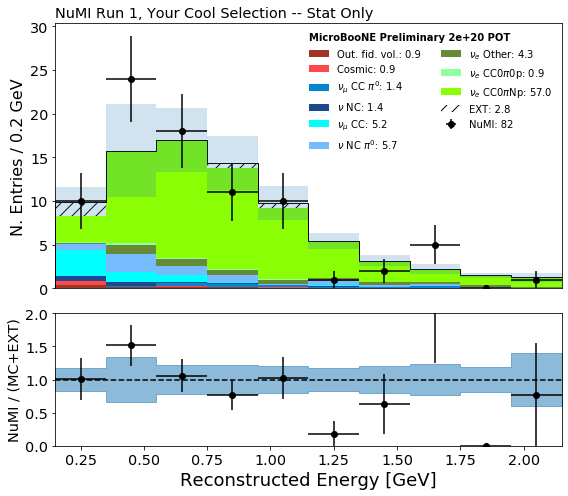

In [33]:
# Ready for the big moment? 
# We're plotting!!!

# We have many selections to choose from, let's pick one
QUERY = NPLCUTQ 
# Let's decide what variable to plot (and the bin size)
VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.15,2.15), r"Reconstructed Energy [GeV]"

# For all the plotting options look at plotting.py
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented), NOTE:there's a tiny issue with the dirt sample that needs a workaround
    #draw_data = False, # we can also plot the MC only
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. Let's use it!
    stacksort=3, # oder of categories
    title=XTIT,  # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, Your Cool Selection -- Partial Sys',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_S_Intrinsic_ReintFluxXsPPFX.pdf")
#print('%s P-value Full Cov = %.4f Stat Only = %.4f Diag Only = %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag']))

In [34]:
# Calculate data-MC agrement accordinf to p-value (definition in plotter.py)
print('%s P-value Full Cov = %.4f Stat Only = %.4f Diag Only = %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag']))

reco_e P-value Full Cov = 0.1096 Stat Only = 0.0284 Diag Only = 0.1631 


In [37]:
# Wanna do a list dump of your events?
print(data.query(QUERY)[["run","sub","evt"]])
# and maybe create a small samweb definition that isolates those (so you can look at the in the event display?)
f = data.query(QUERY)[["run","sub",]]
query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
# print what the query for sameweb would look like:
print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_beam_good and run_number "+query4SamWeb)


         run  sub    evt
entry                   
46561   5092   69   3484
54381   5154  200  10049
67555   5051  146   7341
71262   4969  146   7330
72470   5179   95   4798
...      ...  ...    ...
565802  6283   38   1924
591776  5603   21   1086
597279  6588   24   1203
598321  6489    5    265
600878  5966  120   6036

[84 rows x 3 columns]
defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_beam_good and run_number 5092.69,5154.200,5051.146,4969.146,5179.95,4969.97,4962.74,5233.71,5337.36,5133.2,4955.8,5037.17,5896.51,5127.22,6085.19,6324.157,6630.37,6339.110,6348.67,5449.98,6011.102,6609.52,6036.11,5440.51,6226.146,6423.63,6623.17,6313.74,5390.54,6533.60,6690.41,6692.4,5384.32,6600.23,6533.145,6573.68,6305.42,6631.41,6563.65,6341.72,5428.9,6376.127,6350.5,5935.59,5891.176,6026.62,5606.33,6483.119,5975.43,5938.12,6690.110,6319.98,5332.115,5390.8,6326.16,5061.38,5437.87,6602.14,6697.131,6404.62,5589.34,6461.109,6483.68,5938.56,6354.137,6408.45,6375.120,6090.158,6304.2

reco_nu_vtx_sce_x 10 (0, 260) vtx x [cm]
IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys
reco_nu_vtx_sce_y 10 (-120, 120) vtx y [cm]
IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys
reco_nu_vtx_sce_z 10 (0, 1030) vtx z [cm]
IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys
pi0_score 10 (0, 1.0) $\pi^0$ BDT response
IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys
nonpi0_score 10 (0, 1.0) non-$\pi^0$ BDT response
IN COVMATRIX_XS_PPFX
Universes 600
Universes 600
Universes 600
draw Sys


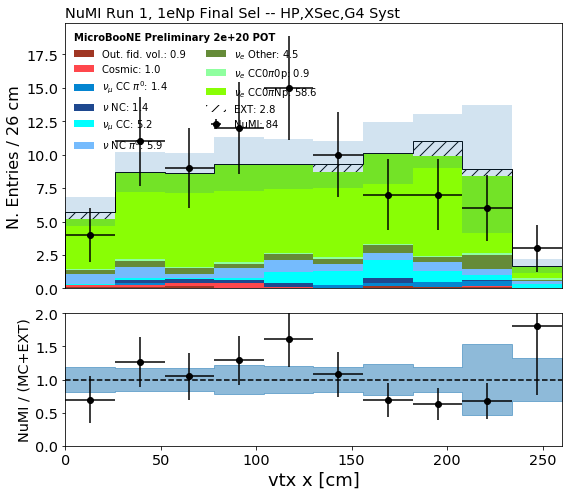

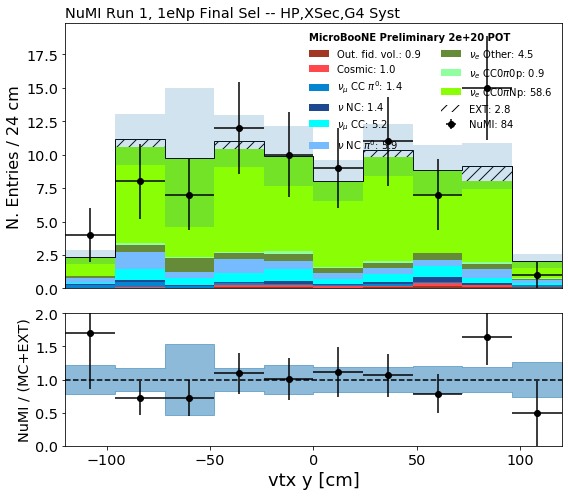

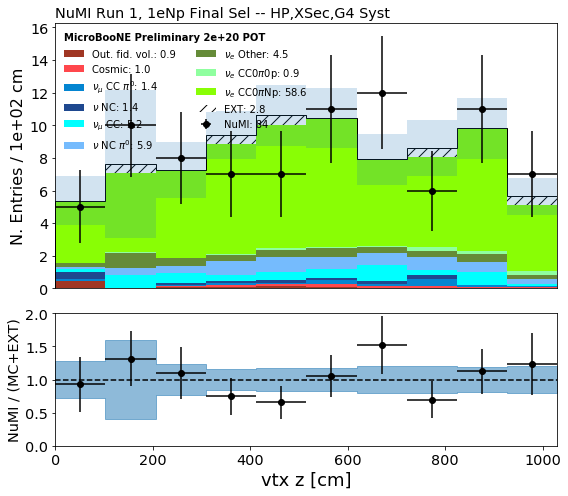

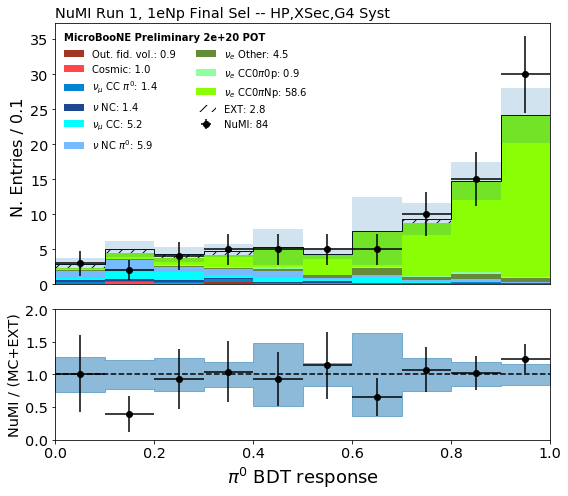

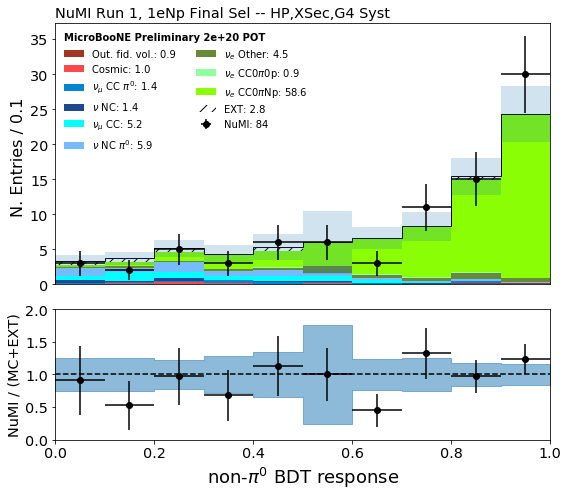

In [38]:
# Let's do a plot dump: define a loads of plots you want to take a look at and go bananas.
plots = []

# Just a few as as examples. 
# PLEASE: if you're doing a BDT optimization, you better check the data-MC agreement of your input variables BEFORE
# you select on them (and before you train the BDT using them)
plots.append(['reco_nu_vtx_sce_x',10,(0,260),"vtx x [cm]"])
plots.append(['reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"])
plots.append(['reco_nu_vtx_sce_z',10,(0,1030),"vtx z [cm]"])

if USEBDT:
    plots.append(['pi0_score',10,(0,1.0),"$\pi^0$ BDT response"])
    plots.append(['nonpi0_score',10,(0,1.0),"non-$\pi^0$ BDT response"])

# I'm also saving the p-values in a text file for convenience
f = open("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/NuMIPValuesSys_1eNp.txt", "w")
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        genieweight = "weightSplineTimesTuneTimesPPFX",
        draw_sys=True,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    ax1.set_title('NuMI Run 1, 1eNp Final Sel -- HP,XSec,G4 Syst',loc='left')
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/"+VARIABLE+"_S_FullMC_ReintFluxXsPPFX.pdf")
    f.write('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")
    #break
f.close()